In [23]:
print(__doc__)

!pip3 install statsmodels --upgrade
!pip3 install imblearn --upgrade

import scipy.stats as scp_stats
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.special import expit
import statsmodels.api as sm

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn import metrics
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

from imblearn.over_sampling import SMOTE
import missingno as msno
import seaborn as sns

# pd.options.display.max_rows = 20
pd.options.display.float_format = "{:.1f}".format
df = pd.read_csv("https://raw.githubusercontent.com/WenxuanHuang/ML-for-COVID-19-dataset/main/all_training.csv", sep=',')

Automatically created module for IPython interactive environment
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable


In [24]:
#Using robust scaling as normalization method

# Column selection
df_features = df.iloc[:,np.r_[3,5:34]].copy()

# create a scaler object
scaler = RobustScaler()

# fit and transform the data
df_normalized = pd.DataFrame(scaler.fit_transform(df_features), columns=df_features.columns)
n_samples, n_features = df_features.shape

# define row and column index
col = df_normalized.columns
row = [i for i in range(df_normalized.shape[0])]

# define imputer
imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')

# fit on the dataset
imputer.fit(df_normalized)

# transform the dataset
df_normalized_imputed = imputer.transform(df_normalized)

# convert back to pandas dataframe and rename back to df_normalized
df_normalized = pd.DataFrame(data=df_normalized_imputed, index=row, columns=col)

/Users/wenxuanhuang/Library/Python/3.8/lib/python/site-packages/sklearn/impute/_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


In [25]:
# Logistic regression

# Data preparation
X = df_normalized
y = df.target
X = X.to_numpy()

# Cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [26]:
# Create first pipeline for base without reducing features.

pipe = Pipeline([('classifier' , SVC())])
# pipe = Pipeline([('classifier', RandomForestClassifier())])

# Create param grid.

param_grid = [
    # {'classifier' : [LogisticRegression()],
    #  'classifier__penalty' : ['l1', 'l2'],
    # 'classifier__C' : np.logspace(0, 4, 10),
    # 'classifier__solver' : ['liblinear'],
    # 'classifier__class_weight' : ['balanced']},
    # {'classifier' : [RandomForestClassifier()],
    # 'classifier__n_estimators' : list(range(10,101,10)),
    # 'classifier__max_features' : list(range(4, 10)),
    # 'classifier__criterion' : ["gini", "entropy"],
    # 'classifier__class_weight' : ["balanced", "balanced_subsample"]},
    {'classifier' : [SVC()],
     'classifier__kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
     'classifier__gamma' : ['scale', 'auto']}
]

# Create grid search object

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# Fit on data

best_clf = clf.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [27]:
best_clf.best_estimator_.get_params()['classifier']

SVC(kernel='linear')

In [28]:
print('Model accuracy is',best_clf.score(X_test, y_test))

Model accuracy is 0.8310940499040307


In [29]:
probs = best_clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='GridSearchCV (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

AttributeError: predict_proba is not available when  probability=False

In [8]:
# Rerunning above with resampled data

sm = SMOTE()
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

best_clf = clf.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [9]:
best_clf.best_estimator_.get_params()['classifier']

LogisticRegression(class_weight='balanced', penalty='l1', solver='liblinear')

In [10]:
print('Model accuracy is',best_clf.score(X_test, y_test))

Model accuracy is 0.8272552783109405


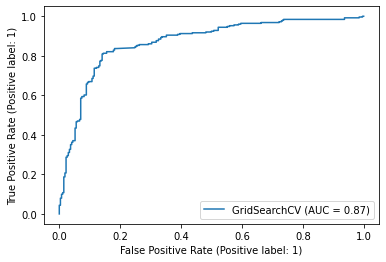

In [11]:
slt_disp = metrics.plot_roc_curve(best_clf, X_test, y_test)

In [12]:
classes = best_clf.predict(X_test)  
accuracy = metrics.accuracy_score(classes, y_test)   
balanced_accuracy = metrics.balanced_accuracy_score(classes, y_test)
precision = metrics.precision_score(classes, y_test)    
average_precision = metrics.average_precision_score(classes, y_test)    
f1_score = metrics.f1_score(classes, y_test)    
recall = metrics.recall_score(classes, y_test)

print (accuracy, balanced_accuracy, precision, average_precision, f1_score, recall, roc_auc)

0.8272552783109405 0.8270252324037185 0.8207171314741036 0.7599489707396108 0.8207171314741035 0.8207171314741036 0.8659288770842555


In [13]:
print(metrics.classification_report(classes, y_test))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       270
           1       0.82      0.82      0.82       251

    accuracy                           0.83       521
   macro avg       0.83      0.83      0.83       521
weighted avg       0.83      0.83      0.83       521

